<a href="https://www.kaggle.com/code/mohamedchahed/face-detection-yolo-nas?scriptVersionId=139937533" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📦 Required Dependencies

In [1]:
!pip install super_gradients
import os
import shutil
import random
from tqdm.notebook import tqdm
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
import torch
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


# 💾 Datasets and DataLoaders

In [4]:
dataset_params = {
    'data_dir':'/kaggle/input/face-detection-dataset',
    'train_images_dir':'/kaggle/input/face-detection-dataset/images/train',
    'train_labels_dir':'/kaggle/input/face-detection-dataset/labels/train',
    'val_images_dir':'/kaggle/input/face-detection-dataset/images/val',
    'val_labels_dir':'/kaggle/input/face-detection-dataset/labels/val',
    'test_images_dir':'/kaggle/input/face-detection-dataset/images/val',
    'test_labels_dir':'/kaggle/input/face-detection-dataset/labels/val',
    'classes': ['face']    
}
     

[2023-08-14 21:50:00] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [23]:
MODEL_ARCH = 'yolo_nas_l'
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
MAX_EPOCHS = 20
CHECKPOINT_DIR = f'/kaggle/working/'
EXPERIMENT_NAME = f'yolo_nas_face'
     

In [25]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

Caching annotations: 100%|██████████| 3347/3347 [00:04<00:00, 782.97it/s]


In [8]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

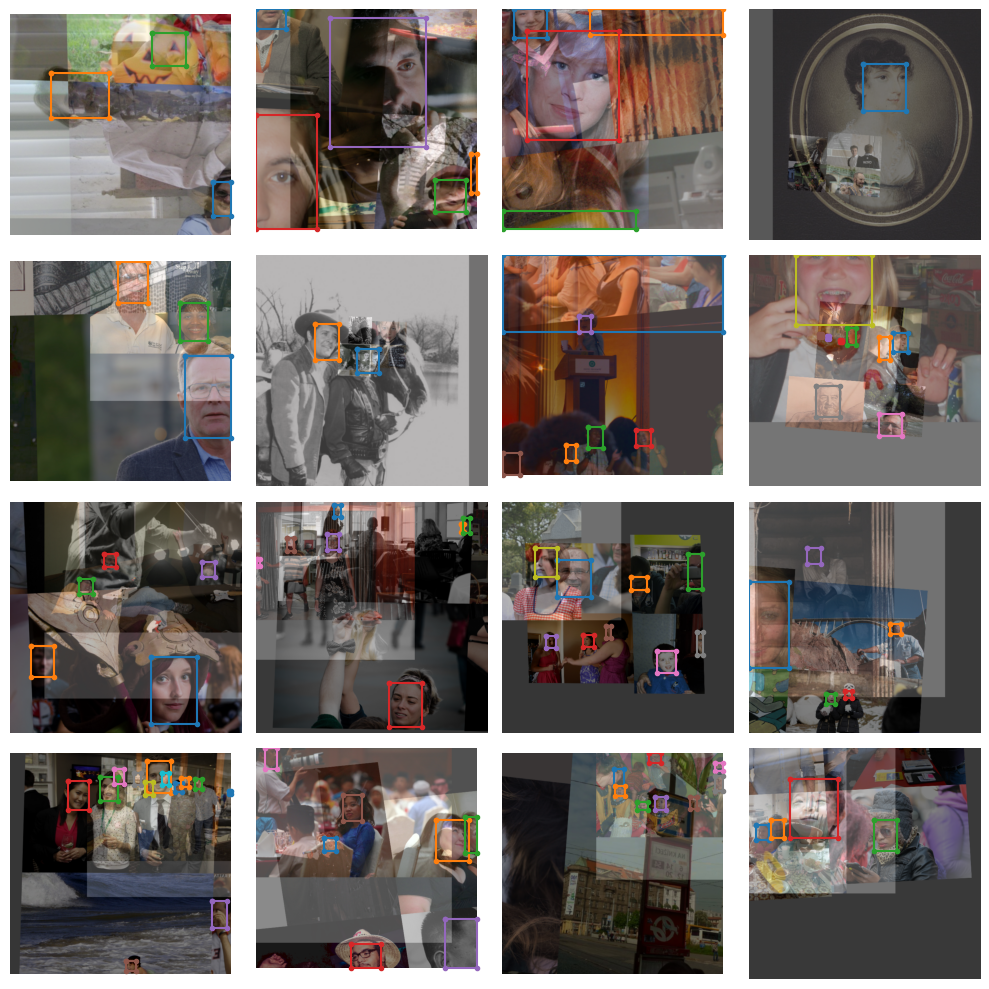

In [9]:
train_data.dataset.plot()

# ⚙️ Initializing the model

In [26]:
model = models.get(
    MODEL_ARCH, 
    num_classes=len(dataset_params['classes']), 
    pretrained_weights="coco"
)

[2023-08-14 22:03:48] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


# 🔍 Training parameters

In [30]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}
     

# ⏳ Training the model

In [28]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [31]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

The console stream is now moved to /kaggle/working/yolo_nas_face/console_Aug14_22_05_47.txt


[2023-08-14 22:05:58] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-14 22:06:01] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 13386      (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         1673       (len(train_loader))
    - Gradient updates per epoch:   1673       (len(train_loader) / batch_accumulate)

[2023-08-14 22:06:01] INFO - sg_trainer.py - Started training for 20 epochs (0/19)

Validating: 100%|██████████| 419/419 [02:07<00:00,  3.30it/s]
[2023-08-14 22:39:42] INFO - base_sg_logger.p

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3668
│   ├── Ppyoloeloss/loss_iou = 0.2627
│   ├── Ppyoloeloss/loss_dfl = 1.269
│   └── Ppyoloeloss/loss = 2.658
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8457
    ├── Ppyoloeloss/loss_iou = 0.1988
    ├── Ppyoloeloss/loss_dfl = 1.0094
    ├── Ppyoloeloss/loss = 1.8473
    ├── Precision@0.50 = 0.0713
    ├── Recall@0.50 = 0.8228
    ├── Map@0.50 = 0.6593
    └── F1@0.50 = 0.1312



Validating epoch 1: 100%|██████████| 419/419 [02:02<00:00,  3.42it/s]
[2023-08-14 23:13:14] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/yolo_nas_face/ckpt_best.pth
[2023-08-14 23:13:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8259294033050537


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8384
│   │   ├── Epoch N-1      = 1.3668 (↘ -0.5285)
│   │   └── Best until now = 1.3668 (↘ -0.5285)
│   ├── Ppyoloeloss/loss_iou = 0.2124
│   │   ├── Epoch N-1      = 0.2627 (↘ -0.0503)
│   │   └── Best until now = 0.2627 (↘ -0.0503)
│   ├── Ppyoloeloss/loss_dfl = 1.0296
│   │   ├── Epoch N-1      = 1.269  (↘ -0.2394)
│   │   └── Best until now = 1.269  (↘ -0.2394)
│   └── Ppyoloeloss/loss = 1.8842
│       ├── Epoch N-1      = 2.658  (↘ -0.7738)
│       └── Best until now = 2.658  (↘ -0.7738)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7096
    │   ├── Epoch N-1      = 0.8457 (↘ -0.136)
    │   └── Best until now = 0.8457 (↘ -0.136)
    ├── Ppyoloeloss/loss_iou = 0.1849
    │   ├── Epoch N-1      = 0.1988 (↘ -0.0139)
    │   └── Best until now = 0.1988 (↘ -0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.9215
    │   ├── Epoch N-1      = 1.0094 (↘ -0.0879)
    │   └── Best until now = 1.0094 (↘ -0.0879)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 419/419 [01:57<00:00,  3.57it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.822
│   │   ├── Epoch N-1      = 0.8384 (↘ -0.0164)
│   │   └── Best until now = 0.8384 (↘ -0.0164)
│   ├── Ppyoloeloss/loss_iou = 0.2096
│   │   ├── Epoch N-1      = 0.2124 (↘ -0.0028)
│   │   └── Best until now = 0.2124 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 1.0133
│   │   ├── Epoch N-1      = 1.0296 (↘ -0.0164)
│   │   └── Best until now = 1.0296 (↘ -0.0164)
│   └── Ppyoloeloss/loss = 1.8526
│       ├── Epoch N-1      = 1.8842 (↘ -0.0316)
│       └── Best until now = 1.8842 (↘ -0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7218
    │   ├── Epoch N-1      = 0.7096 (↗ 0.0121)
    │   └── Best until now = 0.7096 (↗ 0.0121)
    ├── Ppyoloeloss/loss_iou = 0.1845
    │   ├── Epoch N-1      = 0.1849 (↘ -0.0004)
    │   └── Best until now = 0.1849 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.9241
    │   ├── Epoch N-1      = 0.9215 (↗ 0.0026)
    │   └── Best until now = 0.9215 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 

Validating epoch 3: 100%|██████████| 419/419 [01:59<00:00,  3.50it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8294
│   │   ├── Epoch N-1      = 0.822  (↗ 0.0074)
│   │   └── Best until now = 0.822  (↗ 0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.2116
│   │   ├── Epoch N-1      = 0.2096 (↗ 0.002)
│   │   └── Best until now = 0.2096 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 1.0231
│   │   ├── Epoch N-1      = 1.0133 (↗ 0.0098)
│   │   └── Best until now = 1.0133 (↗ 0.0098)
│   └── Ppyoloeloss/loss = 1.87
│       ├── Epoch N-1      = 1.8526 (↗ 0.0173)
│       └── Best until now = 1.8526 (↗ 0.0173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7451
    │   ├── Epoch N-1      = 0.7218 (↗ 0.0233)
    │   └── Best until now = 0.7096 (↗ 0.0355)
    ├── Ppyoloeloss/loss_iou = 0.1908
    │   ├── Epoch N-1      = 0.1845 (↗ 0.0063)
    │   └── Best until now = 0.1845 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.9495
    │   ├── Epoch N-1      = 0.9241 (↗ 0.0254)
    │   └── Best until now = 0.9215 (↗ 0.028)
    ├── Ppyoloeloss/loss = 1.697
    │   

Validating epoch 4: 100%|██████████| 419/419 [02:06<00:00,  3.32it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.812
│   │   ├── Epoch N-1      = 0.8294 (↘ -0.0173)
│   │   └── Best until now = 0.822  (↘ -0.0099)
│   ├── Ppyoloeloss/loss_iou = 0.2064
│   │   ├── Epoch N-1      = 0.2116 (↘ -0.0052)
│   │   └── Best until now = 0.2096 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 1.0049
│   │   ├── Epoch N-1      = 1.0231 (↘ -0.0182)
│   │   └── Best until now = 1.0133 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.8305
│       ├── Epoch N-1      = 1.87   (↘ -0.0395)
│       └── Best until now = 1.8526 (↘ -0.0221)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7633
    │   ├── Epoch N-1      = 0.7451 (↗ 0.0181)
    │   └── Best until now = 0.7096 (↗ 0.0536)
    ├── Ppyoloeloss/loss_iou = 0.1884
    │   ├── Epoch N-1      = 0.1908 (↘ -0.0025)
    │   └── Best until now = 0.1845 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.9465
    │   ├── Epoch N-1      = 0.9495 (↘ -0.003)
    │   └── Best until now = 0.9215 (↗ 0.025)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 5: 100%|██████████| 419/419 [02:06<00:00,  3.31it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8061
│   │   ├── Epoch N-1      = 0.812  (↘ -0.0059)
│   │   └── Best until now = 0.812  (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.2045
│   │   ├── Epoch N-1      = 0.2064 (↘ -0.0019)
│   │   └── Best until now = 0.2064 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 1.0029
│   │   ├── Epoch N-1      = 1.0049 (↘ -0.0021)
│   │   └── Best until now = 1.0049 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.8188
│       ├── Epoch N-1      = 1.8305 (↘ -0.0117)
│       └── Best until now = 1.8305 (↘ -0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7191
    │   ├── Epoch N-1      = 0.7633 (↘ -0.0442)
    │   └── Best until now = 0.7096 (↗ 0.0095)
    ├── Ppyoloeloss/loss_iou = 0.1831
    │   ├── Epoch N-1      = 0.1884 (↘ -0.0052)
    │   └── Best until now = 0.1845 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.919
    │   ├── Epoch N-1      = 0.9465 (↘ -0.0275)
    │   └── Best until now = 0.9215 (↘ -0.0025)
    ├── Ppyoloeloss/loss

Train epoch 6:   1%|          | 18/1673 [00:23<35:55,  1.30s/it, PPYoloELoss/loss=1.83, PPYoloELoss/loss_cls=0.816, PPYoloELoss/loss_dfl=0.992, PPYoloELoss/loss_iou=0.206, gpu_mem=7.11] 
[2023-08-15 01:29:47] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2023-08-15 01:29:47] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2023-08-15 01:29:47] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


# 📈 Inference and Visualization

In [32]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/average_model.pth"
).to(DEVICE)

[2023-08-15 01:32:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working//yolo_nas_face/average_model.pth EMA checkpoint.


[2023-08-15 01:38:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


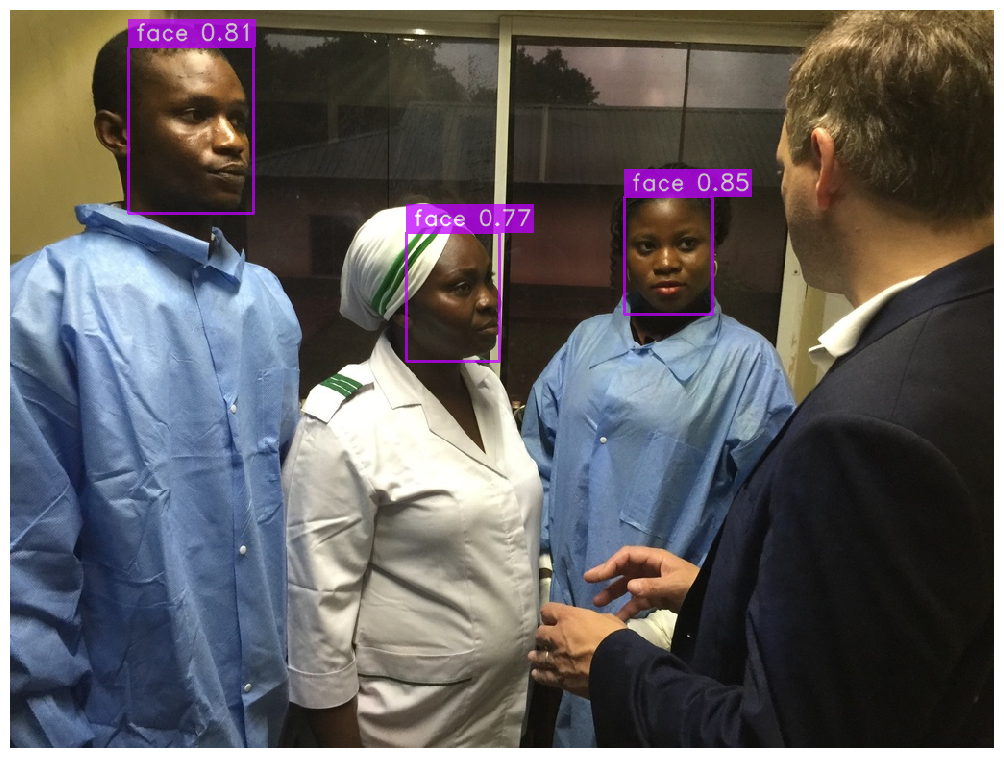

In [34]:
img_1 = "/kaggle/input/face-detection-dataset/images/val/001ea8a8ca78a3bc.jpg"
best_model.predict(img_1).show()

[2023-08-15 01:38:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


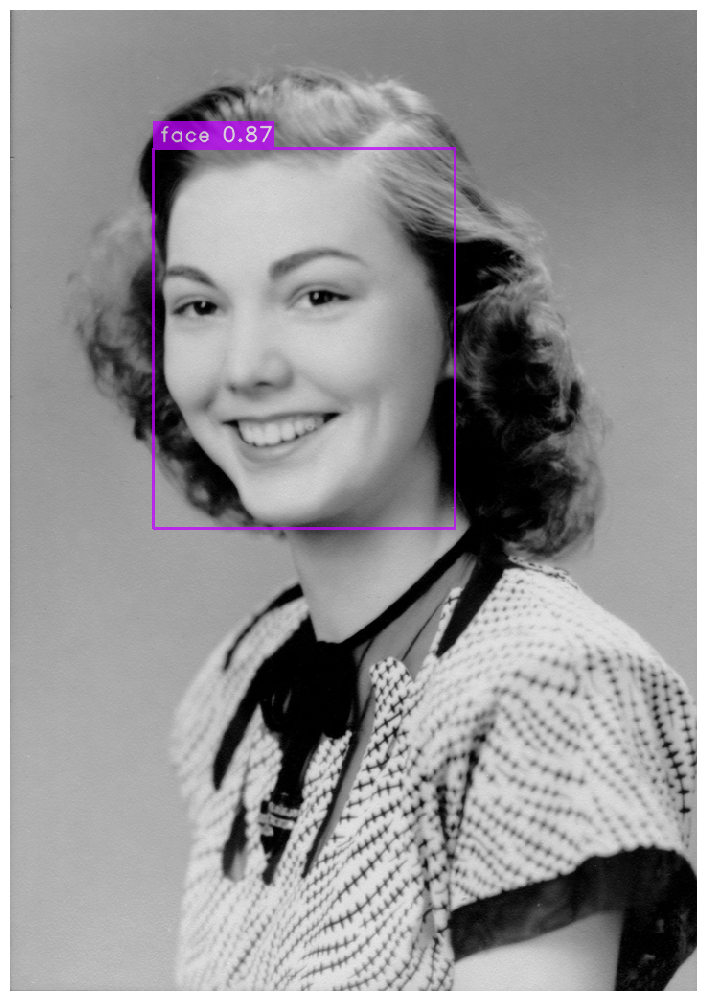

In [35]:
img_2 = "/kaggle/input/face-detection-dataset/images/val/0098312a40cabb46.jpg"
best_model.predict(img_2).show()